In [24]:
# 导入所需库
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input, BatchNormalization, Activation, Conv2D, MaxPooling2D,Add,ZeroPadding2D,AveragePooling2D,Concatenate
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [25]:
train = ImageDataGenerator(
    rescale=1./255,             
    rotation_range=20,           
    width_shift_range=0.2,
    height_shift_range=0.2,    
    fill_mode='nearest'
)
vt = ImageDataGenerator(
    rescale=1./255
)

In [35]:
train_generator = train.flow_from_directory(
    r'E:\practiceMV\dataset2\train',
    target_size=(150,150),
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator, test_generator = vt.flow_from_directory(
    r'E:\practiceMV\dataset2\val',
    target_size=(150,150),
    batch_size=16,
    class_mode='categorical'
), vt.flow_from_directory(
    r'E:\practiceMV\dataset2\test',
    target_size=(150,150),
    batch_size=16,
    class_mode='categorical'
)

Found 14440 images belonging to 15 classes.
Found 3109 images belonging to 15 classes.
Found 3089 images belonging to 15 classes.


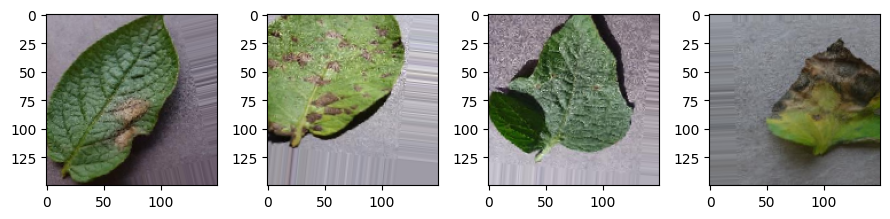

In [36]:
plt.figure(figsize=(9, 9))

for i in range(4):
    plt.subplot(4, 4, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()

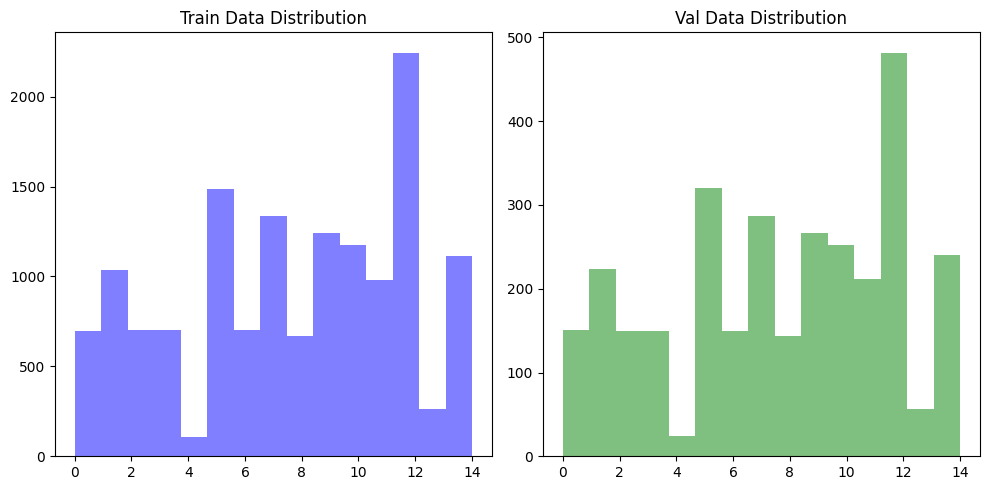

In [37]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Train Data Distribution')
plt.hist(train_generator.labels, bins=15, color='blue', alpha=0.5)
plt.subplot(1, 2, 2)
plt.title('Val Data Distribution')
plt.hist(val_generator.labels, bins=15, color='green', alpha=0.5)
plt.tight_layout()



In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Attention, Concatenate, GlobalAveragePooling2D

# 定义输入形状
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)


x1 = Conv2D(16, (1,1), padding='same', activation='relu')(inputs)

# Second branch
x1 = Conv2D(16, (1,1), padding='same', activation='relu')(inputs)
x1 = Conv2D(16, (1,1), padding='same', activation='relu')(x1)

# Third branch
x1 = Conv2D(32, (1,1), padding='same', activation='relu')(inputs)
x1 = Conv2D(16, (1,1), padding='same', activation='relu')(x1)

x1 = Concatenate(axis=-1)([x1, x1, x1])
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(128, activation='relu')(x1)

# 模型2
x2 = Conv2D(32, (5, 5), activation='relu')(inputs)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(64, (5, 5), activation='relu')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = GlobalAveragePooling2D()(x2)  # 放在 Flatten 之前
x2 = Flatten()(x2)
x2 = Dense(128, activation='relu')(x2)
# 注意力机制
att_layer = Attention()([x1, x2])

# 合并两个模型的输出
merged = Concatenate()([x1, x2, att_layer])

# 输出层
outputs = Dense(15, activation='softmax')(merged)

# 创建模型
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# 打印模型摘要
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_55 (Conv2D)             (None, 220, 220, 32  2432        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 110, 110, 32  0          ['conv2d_55[0][0]']              
 )                              )                                                           

In [39]:
def custom_loss2(y_true, y_pred):
    # Custom loss function implementation
    # Modify this part to define your own loss logic
    diff = y_true - y_pred
    squared_difference = tf.square(diff)
    loss = tf.reduce_mean(squared_difference, axis=-1)  # You can customize the axis as needed
    
    return loss

# Custom accuracy function (Top-2 accuracy)
def custom_accuracy(y_true, y_pred):
    # Custom accuracy considers the top-2 predictions
    top2_accuracy = tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)
    return top2_accuracy

# Compile the model with custom loss and accuracy
model.compile(optimizer='adam', loss=custom_loss2, metrics=[custom_accuracy])

In [40]:
history = model.fit(train_generator, epochs=40, verbose=1,validation_data=val_generator)

Epoch 1/40
903/903 [==============================] - 65s 71ms/step - loss: 0.0556 - custom_accuracy: 0.3973 - val_loss: 0.0504 - val_custom_accuracy: 0.5111
Epoch 2/40
903/903 [==============================] - 62s 68ms/step - loss: 0.0450 - custom_accuracy: 0.6042 - val_loss: 0.0405 - val_custom_accuracy: 0.6665
Epoch 3/40
903/903 [==============================] - 62s 68ms/step - loss: 0.0361 - custom_accuracy: 0.7324 - val_loss: 0.0302 - val_custom_accuracy: 0.7954
Epoch 4/40
903/903 [==============================] - 60s 67ms/step - loss: 0.0311 - custom_accuracy: 0.7917 - val_loss: 0.0285 - val_custom_accuracy: 0.8163
Epoch 5/40
903/903 [==============================] - 62s 68ms/step - loss: 0.0277 - custom_accuracy: 0.8299 - val_loss: 0.0253 - val_custom_accuracy: 0.8639
Epoch 6/40
903/903 [==============================] - 61s 68ms/step - loss: 0.0257 - custom_accuracy: 0.8519 - val_loss: 0.0217 - val_custom_accuracy: 0.8787
Epoch 7/40
903/903 [==============================] 

In [45]:
loss, accuracy = model.evaluate(test_generator, verbose=1)
print('Loss:', loss) 
print('Accuracy:', accuracy)

194/194 [==============================] - 3s 17ms/step - loss: 0.0071 - custom_accuracy: 0.9815
Loss: 0.007052575703710318
Accuracy: 0.9815474152565002


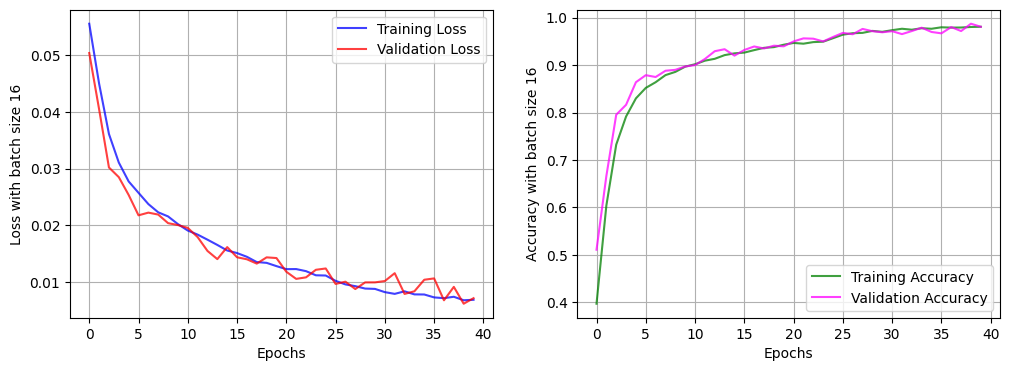

In [46]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue',alpha=0.75)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red',alpha=0.75)
plt.xlabel('Epochs')
plt.ylabel('Loss with batch size 16')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy'], label='Training Accuracy', color='green',alpha=0.75)
plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy', color='magenta',alpha=0.75)
plt.xlabel('Epochs')
plt.ylabel('Accuracy with batch size 16')
plt.legend()
plt.grid()
plt.show()

194/194 [==============================] - 3s 18ms/step
[ 5 10  6 ... 12 12  0]
[ 0  0  0 ... 14 14 14]


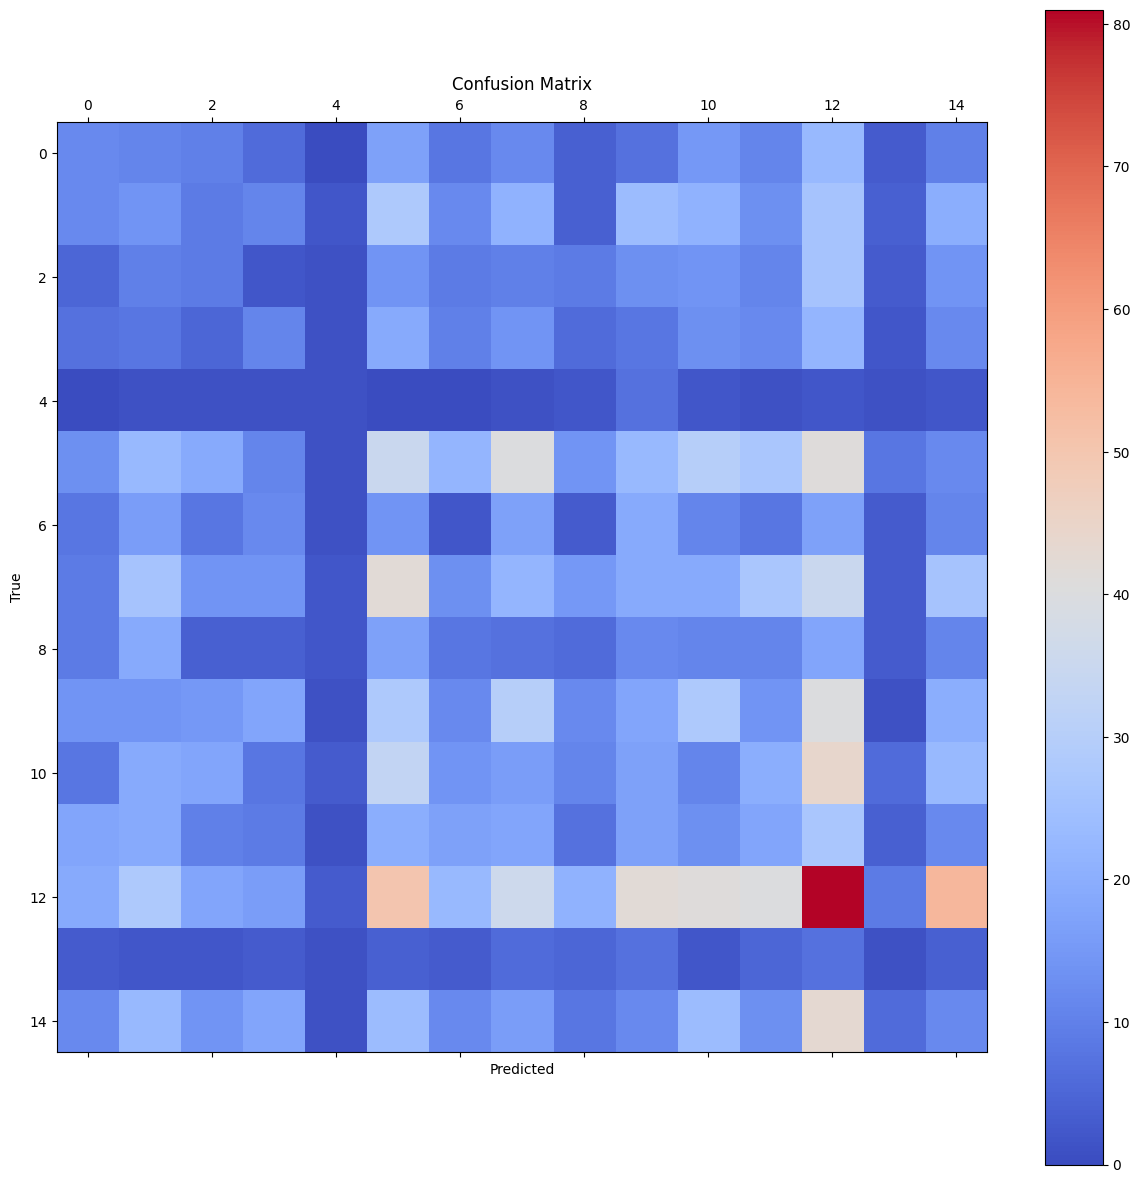

In [47]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
print(y_pred)
print(y_true)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap="coolwarm")
plt.title('Confusion Matrix')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ROC-AUC: 0.4999
Recall: 0.0666
Precision: 0.0671
Sensitivity: 0.5385
Specificity: 0.5217


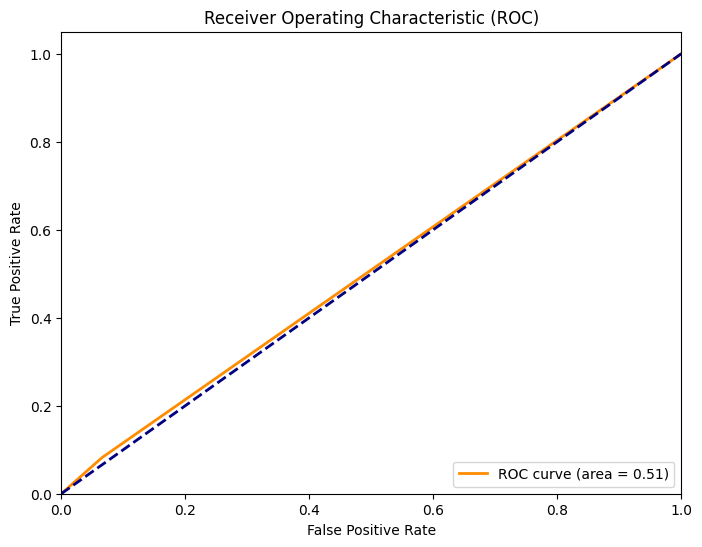

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical

y_true_one_hot = to_categorical(y_true, num_classes=15)
y_pred_one_hot = to_categorical(y_pred, num_classes=15)

roc_auc = roc_auc_score(y_true_one_hot, y_pred_one_hot, average='macro', multi_class='ovr')
print(f'ROC-AUC: {roc_auc:.4f}')

y_pred_labels = np.argmax(y_pred_one_hot, axis=1)

recall = recall_score(y_true, y_pred_labels, average='macro')
print(f'Recall: {recall:.4f}')


precision = precision_score(y_true, y_pred_labels, average='macro')
print(f'Precision: {precision:.4f}')


confusion = confusion_matrix(y_true, y_pred_labels)
sensitivity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')


fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_one_hot.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()